In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import lightgbm
pd.options.mode.chained_assignment = None

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
os.chdir('../..')
DATA_PATH = 'data/processed/'

In [3]:
full_data = pd.read_pickle(DATA_PATH + 'gameweek_data.pkl')
print(full_data.shape)
full_data.head()

(67910, 69)


,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name_player,player_team_promoted_side,player_team_top_6_last_season,team_name_opponent,opponent_team_promoted_side,opponent_team_top_6_last_season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,8,0,0,0,0.0,1,0.0,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,6064,0,0,0,4,3,0.0,0,0,0,0,50,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
1,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,262,0,0,0,0.0,15586,0.0,0,2017-03-04 17:30:00+00:00,04 Mar 17:30,0,0,0,0,0,0,0,0,0,0,0,27,0,9389,0,0,0,1,3,0.0,0,-24,31,55,47,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
2,Petr_Cech,GK,Petr_Cech,0,31,0,0,0,14,0,0,19,0.0,0,0,2,0,0,8,0,4,0,2.4,2,23.6,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,90,0,0,0,0,0,0,8,0,1,3,558286,0,0,0,4,3,0.0,1,0,0,0,55,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
3,Petr_Cech,GK,Petr_Cech,0,35,0,0,0,18,0,0,18,0.0,0,0,2,0,0,262,0,3,0,3.0,15587,30.0,0,2017-03-04 17:30:00+00:00,04 Mar 17:30,0,0,90,0,0,0,0,0,0,14,0,27,4,598246,0,0,0,1,3,0.0,2,-9973,728,10701,54,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
4,Laurent_Koscielny,DEF,Laurent_Koscielny,0,0,0,0,0,0,0,0,0,0.0,0,0,3,0,0,8,0,0,0,0.0,3,0.0,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,136559,0,0,0,4,3,0.0,0,0,0,0,60,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0


In [4]:
test = full_data[full_data['season'] == '2016-17']
test.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name_player,player_team_promoted_side,player_team_top_6_last_season,team_name_opponent,opponent_team_promoted_side,opponent_team_top_6_last_season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,8,0,0,0,0.0,1,0.0,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,6064,0,0,0,4,3,0.0,0,0,0,0,50,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
1,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,262,0,0,0,0.0,15586,0.0,0,2017-03-04 17:30:00+00:00,04 Mar 17:30,0,0,0,0,0,0,0,0,0,0,0,27,0,9389,0,0,0,1,3,0.0,0,-24,31,55,47,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
2,Petr_Cech,GK,Petr_Cech,0,31,0,0,0,14,0,0,19,0.0,0,0,2,0,0,8,0,4,0,2.4,2,23.6,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,90,0,0,0,0,0,0,8,0,1,3,558286,0,0,0,4,3,0.0,1,0,0,0,55,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
3,Petr_Cech,GK,Petr_Cech,0,35,0,0,0,18,0,0,18,0.0,0,0,2,0,0,262,0,3,0,3.0,15587,30.0,0,2017-03-04 17:30:00+00:00,04 Mar 17:30,0,0,90,0,0,0,0,0,0,14,0,27,4,598246,0,0,0,1,3,0.0,2,-9973,728,10701,54,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
4,Laurent_Koscielny,DEF,Laurent_Koscielny,0,0,0,0,0,0,0,0,0,0.0,0,0,3,0,0,8,0,0,0,0.0,3,0.0,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,136559,0,0,0,4,3,0.0,0,0,0,0,60,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0


In [5]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23679 entries, 0 to 67909
Data columns (total 69 columns):
clean_name                         23679 non-null object
pos                                23679 non-null object
name                               23679 non-null object
assists                            23679 non-null int64
attempted_passes                   23679 non-null int64
big_chances_created                23679 non-null int64
big_chances_missed                 23679 non-null int64
bonus                              23679 non-null int64
bps                                23679 non-null int64
clean_sheets                       23679 non-null int64
clearances_blocks_interceptions    23679 non-null int64
completed_passes                   23679 non-null int64
creativity                         23679 non-null float64
dribbles                           23679 non-null int64
ea_index                           23679 non-null int64
element                            23679 non-n

In [5]:
test['clean_name'].nunique()

683

In [7]:
38 * 683

25954

In [8]:
test.shape

(23679, 64)

Not all players have 38 GWs (to be expected due to transfers, players coming into the first team)

In [66]:
test.sort_values(['clean_name', 'gw'], inplace=True)
test['next_recorded_gw'] = test.groupby('clean_name')['gw'].shift(-1)
test['gw_difference'] = test['next_recorded_gw'] - test['gw']
test['gw_difference'].max()

2.0

In [67]:
test[test['gw_difference']==2].head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
1473,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,241,0,0,0,0.0,14425,0.0,0,2017-02-11T12:30:00Z,11 Feb 12:30,0,0,0,0,0,7,0,0,0,0,0,0,25,0,39311,0,0,0,0,2,0.0,0,-826,49,875,76,True,0,0,25,2016-17,1,0,0,0,1,27.0,2.0
1474,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,262,0,0,0,0.0,15601,0.0,0,2017-03-04T17:30:00Z,04 Mar 17:30,0,0,0,0,0,9,0,0,0,0,0,0,27,0,39029,0,0,0,1,3,0.0,0,-92,56,148,76,False,0,0,27,2016-17,1,0,0,0,1,29.0,2.0
48454,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,269,0,0,0,0.0,16258,0.0,0,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,0,0,0,19,0,0,0,0,0,0,27,0,144,0,0,0,2,0,0.0,0,4,9,5,45,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
39877,Abdoulaye_Doucouré,MID,Abdoulaye_Doucouré,0,2,0,0,0,21,0,0,1,0.0,0,0,482,0,0,268,0,0,1,6.6,16117,33.0,0,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,2,0,0,13,0,0,0,0,1,0,27,0,743,0,0,0,4,3,33.0,6,-7,5,12,46,True,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
7179,Abdul Rahman_Baba,DEF,Abdul Rahman_Baba,0,0,0,0,0,0,0,0,0,0.0,0,0,80,0,0,270,0,0,0,0.0,15665,0.0,0,2017-03-06T20:00:00Z,06 Mar 20:00,0,0,0,0,0,20,0,0,0,0,0,0,27,0,1429,0,0,0,2,1,0.0,0,-3,6,9,55,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0


In [68]:
test[test['clean_name'] == 'Aaron_Ramsey']

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
1449,Aaron_Ramsey,MID,Aaron_Ramsey,0,26,0,0,0,5,0,2,22,4.9,1,0,16,0,0,8,0,3,0,3.0,16,2.2,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,60,0,0,9,0,0,0,0,2,0,1,0,163170,2,0,1,4,3,23.0,2,0,0,0,80,True,0,0,1,2016-17,1,0,1,0,0,2.0,1.0
1450,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,13,0,0,0,0.0,541,0.0,0,2016-08-20T16:30:00Z,20 Aug 17:30,0,0,0,0,0,8,0,0,0,0,0,0,2,0,96836,0,0,0,0,0,0.0,0,-74173,1610,75783,79,False,0,0,2,2016-17,1,0,0,0,1,3.0,1.0
1451,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,28,0,0,0,0.0,1081,0.0,0,2016-08-27T14:00:00Z,27 Aug 15:00,0,0,0,0,0,18,0,0,0,0,0,0,3,0,61959,0,0,0,3,1,0.0,0,-35326,148,35474,78,False,0,0,3,2016-17,1,1,0,0,0,4.0,1.0
1452,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,31,0,0,0,0.0,1631,0.0,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,0,0,0,13,0,0,0,0,0,0,4,0,51872,0,0,0,1,2,0.0,0,-10374,159,10533,78,True,0,0,4,2016-17,1,0,0,0,1,5.0,1.0
1453,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,43,0,0,0,0.0,2212,0.0,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,0,0,0,7,0,0,0,0,0,0,5,0,48310,0,0,0,4,1,0.0,0,-3690,73,3763,78,False,0,0,5,2016-17,1,0,1,0,0,6.0,1.0
1454,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,51,0,0,0,0.0,2796,0.0,0,2016-09-24T16:30:00Z,24 Sep 17:30,0,0,0,0,0,4,0,0,0,0,0,0,6,0,44419,0,0,0,0,3,0.0,0,-3950,64,4014,77,True,0,0,6,2016-17,1,1,0,0,0,7.0,1.0
1455,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,61,0,0,0,0.0,3382,0.0,0,2016-10-02T15:30:00Z,02 Oct 16:30,0,0,0,0,0,3,0,0,0,0,0,0,7,0,41937,0,0,0,1,0,0.0,0,-2546,32,2578,77,False,0,0,7,2016-17,1,0,0,0,1,8.0,1.0
1456,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,71,0,0,0,0.0,3971,0.0,0,2016-10-15T14:00:00Z,15 Oct 15:00,0,0,0,0,0,16,0,0,0,0,0,0,8,0,40481,0,0,0,2,3,0.0,0,-1519,49,1568,77,True,0,0,8,2016-17,1,0,0,1,0,9.0,1.0
1457,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,81,0,0,0,0.0,4563,0.0,0,2016-10-22T14:00:00Z,22 Oct 15:00,0,0,0,0,0,12,0,0,0,0,0,0,9,0,39727,0,0,0,0,0,0.0,0,-793,47,840,77,True,0,0,9,2016-17,1,0,0,1,0,10.0,1.0
1458,Aaron_Ramsey,MID,Aaron_Ramsey,1,20,1,0,0,13,0,0,20,21.8,0,0,16,0,0,97,1,0,0,4.8,5157,16.0,2,2016-10-29T11:30:00Z,29 Oct 12:30,0,0,14,0,0,15,0,0,0,0,0,0,10,0,39726,1,0,2,4,1,10.0,4,-89,396,485,76,False,0,0,10,2016-17,1,1,0,0,0,11.0,1.0


Looks like gw_difference = 2 is an artifact of fixtures being moved. This has 2 effects:

- There is a missing GW for the original fixture (causing gw_difference to be 2)
- There is a repeated GW for the rescheduled fixture (causign gw_difference to be 0)

In [69]:
(test.groupby('clean_name').sum()['minutes'] == 0) & (test.groupby('clean_name').count()['gw'] == 38)

clean_name
Aaron_Cresswell                   False
Aaron_Lennon                      False
Aaron_Ramsdale                    False
Aaron_Ramsey                      False
Aaron_Wan-Bissaka                 False
Abdoulaye_Doucouré                False
Abdul Rahman_Baba                  True
Abel_Hernández                    False
Adam_Clayton                      False
Adam_Federici                     False
Adam_Forshaw                      False
Adam_Lallana                      False
Adam_Matthews                      True
Adam_Reach                         True
Adam_Smith                        False
Adama_Diomande                    False
Adama_Traoré                      False
Ademola_Lookman                   False
Adlène_Guédioura                  False
Adnan_Januzaj                     False
Adrian_Mariappa                   False
Adrián_San Miguel del Castillo    False
Ahmed_Elmohamady                  False
Ahmed_Musa                        False
Aiden_O'Neill                

In [70]:
test[test['clean_name'] == 'Abdul Rahman_Baba ']['gw'].count()

0

In [71]:
test[test['clean_name'] == 'Abdul Rahman_Baba ']['minutes'].sum()

0

Looks like players who played 0 minutes but were there at the start of the season still had 38 gameweeks

Therefore all players should have 38 gameweeks unless they joined in the January transfer window or were brought into the first team during the season

If this were true you would expect to see a spike for number of players with only 19 GWs (more players likely to be brought into a team during the transfer window than from the academy/second team)

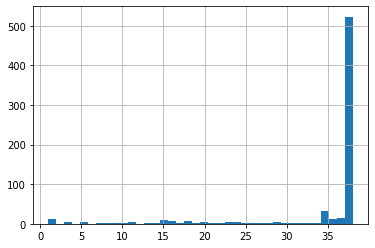

In [49]:
test.groupby('clean_name').count()['gw'].hist(bins=38)

Doesn't seem to be the case with even spread of players with GWs less than 38

In [72]:
(test.groupby('clean_name').count()['gw']==38).sum()

523

In [73]:
(test.groupby('clean_name').count()['gw']!=38).sum()

160

Could potentially drop players who do not have a full season of data (but may lose valuable information regarding January transfers)

In [74]:
subsample = test.groupby('clean_name').count().reset_index()
subsample[subsample['gw'] == 5]

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
59,Angus_Gunn,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4
493,Moses_Makasi,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4
506,Nathan_Holland,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4
562,Rhian_Brewster,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4
598,Scott_McTominay,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4


In [61]:
test[test['clean_name'] == 'Angus_Gunn']

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
50664,Angus_Gunn,GK,Angus_Gunn,0,0,0,0,0,0,0,0,0,0.0,0,0,668,0,0,344,0,0,0,0.0,21261,0.0,0,2017-04-30T13:05:00Z,30 Apr 14:05,0,0,0,0,0,12,0,0,0,0,0,0,35,0,0,0,0,0,2,2,0.0,0,0,0,0,40,False,0,0,35,2016-17,1,0,0,0,0,36.0,1.0
50665,Angus_Gunn,GK,Angus_Gunn,0,0,0,0,0,0,0,0,0,0.0,0,0,668,0,0,358,0,0,0,0.0,21997,0.0,0,2017-05-06T11:30:00Z,06 May 12:30,0,0,0,0,0,5,0,0,0,0,0,0,36,0,75,0,0,0,0,5,0.0,0,46,59,13,40,True,0,0,36,2016-17,1,0,0,0,0,37.0,1.0
50666,Angus_Gunn,GK,Angus_Gunn,0,0,0,0,0,0,0,0,0,0.0,0,0,668,0,0,364,0,0,0,0.0,22997,0.0,0,2017-05-13T11:30:00Z,13 May 12:30,0,0,0,0,0,8,0,0,0,0,0,0,37,0,148,0,0,0,1,2,0.0,0,57,80,23,40,True,0,0,37,2016-17,1,0,0,0,0,37.0,0.0
50667,Angus_Gunn,GK,Angus_Gunn,0,0,0,0,0,0,0,0,0,0.0,0,0,668,0,0,338,0,0,0,0.0,22996,0.0,0,2017-05-16T19:00:00Z,16 May 20:00,0,0,0,0,0,19,0,0,0,0,0,0,37,0,148,0,0,0,1,3,0.0,0,57,80,23,40,True,0,0,37,2016-17,1,0,0,0,0,38.0,1.0
50668,Angus_Gunn,GK,Angus_Gunn,0,0,0,0,0,0,0,0,0,0.0,0,0,668,0,0,380,0,0,0,0.0,23673,0.0,0,2017-05-21T14:00:00Z,21 May 15:00,0,0,0,0,0,18,0,0,0,0,0,0,38,0,264,0,0,0,5,0,0.0,0,87,125,38,40,False,0,0,38,2016-17,1,0,0,0,0,NaN,NaN


All the above players had their GWs at the end of the season - likely to be young players put on the bench or play few minutes given that the season is almost wrapped up

In [64]:
subsample = test.groupby('clean_name').count().reset_index()
subsample[subsample['gw'] == 27]

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
35,Alex_Palmer,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,26,26
579,Ryan_Allsop,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,26,26


In [65]:
test[test['clean_name'] == 'Ryan_Allsop']

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
47904,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,116,0,0,0,0.0,6938,0.0,0,2016-11-19T15:00:00Z,19 Nov 15:00,0,0,0,0,0,14,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0.0,0,0,0,0,40,False,0,0,12,2016-17,1,0,0,0,0,13.0,1.0
47905,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,121,0,0,0,0.0,7539,0.0,0,2016-11-27T14:15:00Z,27 Nov 14:15,0,0,0,0,0,1,0,0,0,0,0,0,13,0,473,0,0,0,1,3,0.0,0,348,371,23,40,False,0,0,13,2016-17,1,0,0,0,0,14.0,1.0
47906,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,131,0,0,0,0.0,8143,0.0,0,2016-12-04T13:30:00Z,04 Dec 13:30,0,0,0,0,0,9,0,0,0,0,0,0,14,0,705,0,0,0,3,4,0.0,0,162,219,57,40,True,0,0,14,2016-17,1,0,0,0,0,15.0,1.0
47907,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,142,0,0,0,0.0,8748,0.0,0,2016-12-10T15:00:00Z,10 Dec 15:00,0,0,0,0,0,3,0,0,0,0,0,0,15,0,1055,0,0,0,2,3,0.0,0,260,322,62,40,False,0,0,15,2016-17,1,0,0,0,0,16.0,1.0
47908,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,151,0,0,0,0.0,9358,0.0,0,2016-12-13T19:45:00Z,13 Dec 19:45,0,0,0,0,0,8,0,0,0,0,0,0,16,0,1263,0,0,0,0,1,0.0,0,141,178,37,40,True,0,0,16,2016-17,1,0,0,0,0,17.0,1.0
47909,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,161,0,0,0,0.0,9972,0.0,0,2016-12-18T13:30:00Z,18 Dec 13:30,0,0,0,0,0,13,0,0,0,0,0,0,17,0,1427,0,0,0,3,1,0.0,0,97,155,58,40,True,0,0,17,2016-17,1,0,0,0,0,18.0,1.0
47910,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,173,0,0,0,0.0,10588,0.0,0,2016-12-26T15:00:00Z,26 Dec 15:00,0,0,0,0,0,4,0,0,0,0,0,0,18,0,1598,0,0,0,0,3,0.0,0,103,175,72,40,False,0,0,18,2016-17,1,0,0,0,0,19.0,1.0
47911,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,189,0,0,0,0.0,11206,0.0,0,2016-12-31T15:00:00Z,31 Dec 15:00,0,0,0,0,0,16,0,0,0,0,0,0,19,0,1842,0,0,0,3,0,0.0,0,185,251,66,40,False,0,0,19,2016-17,1,0,0,0,0,20.0,1.0
47912,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,191,0,0,0,0.0,11828,0.0,0,2017-01-03T19:45:00Z,03 Jan 19:45,0,0,0,0,0,1,0,0,0,0,0,0,20,0,2035,0,0,0,3,3,0.0,0,168,270,102,40,True,0,0,20,2016-17,1,0,0,0,0,21.0,1.0
47913,Ryan_Allsop,GK,Ryan_Allsop,0,0,0,0,0,0,0,0,0,0.0,0,0,600,0,0,203,0,0,0,0.0,12452,0.0,0,2017-01-14T15:00:00Z,14 Jan 15:00,0,0,0,0,0,7,0,0,0,0,0,0,21,0,2376,0,0,0,1,3,0.0,0,260,458,198,40,False,0,0,21,2016-17,1,0,0,0,0,22.0,1.0


Not entirely sure what's happening here (possibly still players who joined the first team mid season)

## Create new set of features

__Add double GW flag:__

In [130]:
test = full_data[full_data['season'] == '2016-17']
test.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,8,0,0,0,0.0,1,0.0,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,0,0,0,9,0,0,0,0,0,0,1,0,6064,0,0,0,4,3,0.0,0,0,0,0,50,True,0,0,1,2016-17,1,0,0,1,0
1,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,13,0,0,0,0.0,526,0.0,0,2016-08-20T16:30:00Z,20 Aug 17:30,0,0,0,0,0,8,0,0,0,0,0,0,2,0,7400,0,0,0,0,0,0.0,0,-578,153,731,50,False,0,0,2,2016-17,1,0,0,1,0
2,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,28,0,0,0,0.0,1066,0.0,0,2016-08-27T14:00:00Z,27 Aug 15:00,0,0,0,0,0,18,0,0,0,0,0,0,3,0,7708,0,0,0,3,1,0.0,0,-571,150,721,50,False,0,0,3,2016-17,1,1,0,0,0
3,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,31,0,0,0,0.0,1616,0.0,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,0,0,0,13,0,0,0,0,0,0,4,0,8072,0,0,0,1,2,0.0,0,-449,183,632,49,True,0,0,4,2016-17,1,1,0,0,0
4,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,43,0,0,0,0.0,2197,0.0,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,0,0,0,7,0,0,0,0,0,0,5,0,8379,0,0,0,4,1,0.0,0,-158,172,330,49,False,0,0,5,2016-17,1,1,0,0,0


In [131]:
test.sort_values(['season', 'clean_name', 'gw'], inplace=True)
test['next_recorded_gw'] = test.groupby(['clean_name', 'season', 'pos'])['gw'].shift(-1)
test['gw_difference'] = test['next_recorded_gw'] - test['gw']

In [132]:
test[test['gw_difference'] == 2]

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
1473,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,241,0,0,0,0.0,14425,0.0,0,2017-02-11T12:30:00Z,11 Feb 12:30,0,0,0,0,0,7,0,0,0,0,0,0,25,0,39311,0,0,0,0,2,0.0,0,-826,49,875,76,True,0,0,25,2016-17,1,0,0,0,1,27.0,2.0
1474,Aaron_Ramsey,MID,Aaron_Ramsey,0,0,0,0,0,0,0,0,0,0.0,0,0,16,0,0,262,0,0,0,0.0,15601,0.0,0,2017-03-04T17:30:00Z,04 Mar 17:30,0,0,0,0,0,9,0,0,0,0,0,0,27,0,39029,0,0,0,1,3,0.0,0,-92,56,148,76,False,0,0,27,2016-17,1,0,0,0,1,29.0,2.0
48454,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,269,0,0,0,0.0,16258,0.0,0,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,0,0,0,19,0,0,0,0,0,0,27,0,144,0,0,0,2,0,0.0,0,4,9,5,45,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
39877,Abdoulaye_Doucouré,MID,Abdoulaye_Doucouré,0,2,0,0,0,21,0,0,1,0.0,0,0,482,0,0,268,0,0,1,6.6,16117,33.0,0,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,2,0,0,13,0,0,0,0,1,0,27,0,743,0,0,0,4,3,33.0,6,-7,5,12,46,True,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
7179,Abdul Rahman_Baba,DEF,Abdul Rahman_Baba,0,0,0,0,0,0,0,0,0,0.0,0,0,80,0,0,270,0,0,0,0.0,15665,0.0,0,2017-03-06T20:00:00Z,06 Mar 20:00,0,0,0,0,0,20,0,0,0,0,0,0,27,0,1429,0,0,0,2,1,0.0,0,-3,6,9,55,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
24377,Adam_Clayton,MID,Adam_Clayton,0,62,0,0,0,20,0,3,57,14.3,0,0,283,0,0,264,1,2,0,2.9,15894,14.8,1,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,90,0,0,14,0,0,0,0,12,0,27,0,46166,1,2,0,0,2,0.0,2,-911,1849,2760,43,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
24491,Adam_Forshaw,MID,Adam_Forshaw,0,0,0,0,0,0,0,0,0,0.0,0,0,286,0,0,264,0,0,0,0.0,15897,0.0,0,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,0,0,0,14,0,0,0,0,0,0,27,0,29985,0,0,0,0,2,0.0,0,-1059,1180,2239,45,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
29134,Adam_Matthews,DEF,Adam_Matthews,0,0,0,0,0,0,0,0,0,0.0,0,0,345,0,0,265,0,0,0,0.0,15979,0.0,0,2017-03-05T16:00:00Z,05 Mar 16:00,0,0,0,0,0,10,0,0,0,0,0,0,27,0,1001,0,0,0,2,0,0.0,0,-7,3,10,40,True,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
24453,Adam_Reach,MID,Adam_Reach,0,0,0,0,0,0,0,0,0,0.0,0,0,285,0,0,264,0,0,0,0.0,15896,0.0,0,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,0,0,0,14,0,0,0,0,0,0,27,0,1016,0,0,0,0,2,0.0,0,-3,2,5,44,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0
45792,Adama_Traoré,MID,Adama_Traoré,0,17,0,0,0,5,0,1,12,15.2,5,0,563,0,0,264,4,2,0,2.9,16205,11.8,1,2017-03-04T15:00:00Z,04 Mar 15:00,0,0,90,1,1,14,0,0,0,0,5,0,27,0,8117,8,2,0,0,2,2.0,2,-545,180,725,48,False,0,0,27,2016-17,1,0,0,0,0,29.0,2.0


In [133]:
test[test['clean_name'] == 'Aaron_Wan-Bissaka']

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference
48443,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,155,0,0,0,0.0,9370,0.0,0,2016-12-14T20:00:00Z,14 Dec 20:00,0,0,0,0,0,11,0,0,0,0,0,0,16,0,0,0,0,0,2,1,0.0,0,0,0,0,45,True,0,0,16,2016-17,1,0,0,0,0,17.0,1.0
48444,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,162,0,0,0,0.0,9984,0.0,0,2016-12-17T12:30:00Z,17 Dec 12:30,0,0,0,0,0,4,0,0,0,0,0,0,17,0,23,0,0,0,1,0,0.0,0,8,11,3,45,True,0,0,17,2016-17,1,0,0,0,0,18.0,1.0
48445,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,180,0,0,0,0.0,10600,0.0,0,2016-12-26T12:30:00Z,26 Dec 12:30,0,0,0,0,0,18,0,0,0,0,0,0,18,0,53,0,0,0,1,1,0.0,0,8,16,8,45,False,0,0,18,2016-17,1,0,0,0,0,19.0,1.0
48446,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,181,0,0,0,0.0,11218,0.0,0,2017-01-01T16:00:00Z,01 Jan 16:00,0,0,0,0,0,1,0,0,0,0,0,0,19,0,66,0,0,0,0,2,0.0,0,-1,7,8,45,False,0,0,19,2016-17,1,0,0,0,0,20.0,1.0
48447,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,192,0,0,0,0.0,11840,0.0,0,2017-01-03T20:00:00Z,03 Jan 20:00,0,0,0,0,0,16,0,0,0,0,0,0,20,0,71,0,0,0,2,1,0.0,0,1,3,2,45,True,0,0,20,2016-17,1,0,0,0,0,21.0,1.0
48448,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,210,0,0,0,0.0,12464,0.0,0,2017-01-14T15:00:00Z,14 Jan 15:00,0,0,0,0,0,20,0,0,0,0,0,0,21,0,86,0,0,0,0,3,0.0,0,2,11,9,45,False,0,0,21,2016-17,1,0,0,0,0,22.0,1.0
48449,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,214,0,0,0,0.0,13095,0.0,0,2017-01-21T15:00:00Z,21 Jan 15:00,0,0,0,0,0,6,0,0,0,0,0,0,22,0,96,0,0,0,1,0,0.0,0,-1,6,7,45,True,0,0,22,2016-17,1,0,0,0,0,23.0,1.0
48450,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,222,0,0,0,0.0,13729,0.0,0,2017-01-31T19:45:00Z,31 Jan 19:45,0,0,0,0,0,2,0,0,0,0,0,0,23,0,107,0,0,0,2,0,0.0,0,0,7,7,45,False,0,0,23,2016-17,1,0,0,0,0,24.0,1.0
48451,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,232,0,0,0,0.0,14372,0.0,0,2017-02-04T15:00:00Z,04 Feb 15:00,0,0,0,0,0,15,0,0,0,0,0,0,24,0,109,0,0,0,4,0,0.0,0,0,2,2,45,True,0,0,24,2016-17,1,0,0,0,0,25.0,1.0
48452,Aaron_Wan-Bissaka,MID,Aaron_Wan-Bissaka,0,0,0,0,0,0,0,0,0,0.0,0,0,612,0,0,247,0,0,0,0.0,15021,0.0,0,2017-02-11T15:00:00Z,11 Feb 15:00,0,0,0,0,0,14,0,0,0,0,0,0,25,0,117,0,0,0,0,1,0.0,0,6,8,2,45,False,0,0,25,2016-17,1,0,0,0,0,26.0,1.0


In [134]:
test['double_gw'] = np.where(
    test['gw_difference'] == 0,
    1,
    0
)

double_gw_temp = test.copy()[test['double_gw'] == 1][['clean_name', 'gw', 'pos', 'double_gw']]
double_gw_temp.head()

test = test.merge(
    double_gw_temp,
    on=['clean_name', 'gw', 'pos'],
    how='left',
    suffixes=('_old', '_flag')
)

test['double_gw_flag'] = test['double_gw_flag'].fillna(0)
test.drop(columns=['double_gw_old'], axis=1, inplace=True)

In [135]:
test.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference,double_gw_flag
0,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,10,0,0,0,0.0,454,0.0,0,2016-08-15T19:00:00Z,15 Aug 20:00,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,2016-17,1,0,0,0,0,2.0,1.0,0.0
1,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,20,0,0,0,0.0,979,0.0,0,2016-08-21T15:00:00Z,21 Aug 16:00,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,2016-17,1,0,0,0,0,3.0,1.0,0.0
2,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,29,0,0,0,0.0,1519,0.0,0,2016-08-28T15:00:00Z,28 Aug 16:00,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,2016-17,1,0,0,0,0,4.0,1.0,0.0
3,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,38,0,0,0,0.0,2069,0.0,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,2016-17,1,0,0,0,0,5.0,1.0,0.0
4,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,46,0,0,0,0.0,2650,0.0,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,2016-17,1,0,0,0,0,6.0,1.0,0.0


__Add flag to indicate player only played part of the season (i.e. total GW less than 38):__

In [136]:
number_of_gw = test.groupby(['clean_name', 'pos', 'season']).count()['gw'].reset_index()
number_of_gw.rename(columns={'gw': 'number_of_gws'}, inplace=True)
number_of_gw.head()

,clean_name,pos,season,number_of_gws
0,Aaron_Cresswell,DEF,2016-17,38
1,Aaron_Lennon,MID,2016-17,38
2,Aaron_Ramsdale,GK,2016-17,1
3,Aaron_Ramsey,MID,2016-17,38
4,Aaron_Wan-Bissaka,MID,2016-17,23


In [137]:
test = test.merge(
    number_of_gw,
    on=['clean_name', 'pos', 'season']
)

test['played_partial_season'] = np.where(
    test['number_of_gws'] != 38,
    1,
    0
)

test.drop(columns=['number_of_gws'], axis=1, inplace=True)

In [12]:
test.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name_player,player_team_promoted_side,player_team_top_6_last_season,team_name_opponent,opponent_team_promoted_side,opponent_team_top_6_last_season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,8,0,0,0,0.0,1,0.0,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,6064,0,0,0,4,3,0.0,0,0,0,0,50,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
1,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,262,0,0,0,0.0,15586,0.0,0,2017-03-04T17:30:00Z,04 Mar 17:30,0,0,0,0,0,0,0,0,0,0,0,27,0,9389,0,0,0,1,3,0.0,0,-24,31,55,47,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
2,Petr_Cech,GK,Petr_Cech,0,31,0,0,0,14,0,0,19,0.0,0,0,2,0,0,8,0,4,0,2.4,2,23.6,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,90,0,0,0,0,0,0,8,0,1,3,558286,0,0,0,4,3,0.0,1,0,0,0,55,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
3,Petr_Cech,GK,Petr_Cech,0,35,0,0,0,18,0,0,18,0.0,0,0,2,0,0,262,0,3,0,3.0,15587,30.0,0,2017-03-04T17:30:00Z,04 Mar 17:30,0,0,90,0,0,0,0,0,0,14,0,27,4,598246,0,0,0,1,3,0.0,2,-9973,728,10701,54,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
4,Laurent_Koscielny,DEF,Laurent_Koscielny,0,0,0,0,0,0,0,0,0,0.0,0,0,3,0,0,8,0,0,0,0.0,3,0.0,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,136559,0,0,0,4,3,0.0,0,0,0,0,60,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0


__Create adjusted GW to only be consecutive numbers:__

In [150]:
test['gw_adj'] = test.groupby(['clean_name', 'pos', 'season']).cumcount() + 1

In [151]:
# For players who played partial season keep original gw
test['gw_adj'] = np.where(
    test['played_partial_season'] == 1,
    test['gw'],
    test['gw_adj']
)

In [154]:
test[test['clean_name'] == 'Laurent_Koscielny'].head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID,next_recorded_gw,gw_difference,double_gw_flag,played_partial_season,gw_adj
13744,Laurent_Koscielny,DEF,Laurent_Koscielny,0,0,0,0,0,0,0,0,0,0.0,0,0,3,0,0,8,0,0,0,0.0,3,0.0,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,0,0,0,9,0,0,0,0,0,0,1,0,136559,0,0,0,4,3,0.0,0,0,0,0,60,True,0,0,1,2016-17,1,1,0,0,0,2.0,1.0,0.0,0,1
13745,Laurent_Koscielny,DEF,Laurent_Koscielny,0,44,0,0,1,30,1,11,41,0.3,0,0,3,0,0,13,0,0,0,2.7,528,23.6,0,2016-08-20T16:30:00Z,20 Aug 17:30,0,0,90,0,0,8,0,0,0,0,8,0,2,0,130639,0,0,1,0,0,3.0,7,-16712,1409,18121,60,False,0,0,2,2016-17,1,1,0,0,0,3.0,1.0,0.0,0,2
13746,Laurent_Koscielny,DEF,Laurent_Koscielny,0,43,0,0,0,21,0,16,36,0.0,0,0,3,0,0,28,0,1,0,4.1,1068,38.6,0,2016-08-27T14:00:00Z,27 Aug 15:00,0,0,90,0,0,18,0,0,0,0,3,0,3,0,160761,0,1,0,3,1,2.0,2,6932,13818,6886,60,False,0,0,3,2016-17,1,1,0,0,0,4.0,1.0,0.0,0,3
13747,Laurent_Koscielny,DEF,Laurent_Koscielny,0,70,0,0,2,30,0,5,69,2.3,0,0,3,0,0,31,0,1,1,7.3,1618,49.2,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,90,0,0,13,0,0,0,0,6,0,4,0,189746,0,1,0,1,2,21.0,10,11131,21166,10035,60,True,0,0,4,2016-17,1,1,0,0,0,5.0,1.0,0.0,0,4
13748,Laurent_Koscielny,DEF,Laurent_Koscielny,0,51,0,0,0,17,0,5,48,0.1,0,0,3,0,0,43,0,1,0,1.0,2199,9.8,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,90,0,0,7,0,0,0,0,9,0,5,0,259533,0,0,0,4,1,0.0,2,49043,55464,6421,60,False,0,0,5,2016-17,1,1,0,0,0,6.0,1.0,0.0,0,5


In [155]:
test['opponent_team'].unique()

array([ 4,  2, 10, 18, 19, 13, 12,  5, 15,  6, 14, 17, 11,  1,  9,  3,  7,
       16,  8, 20])

In [156]:
list(test.columns)

['clean_name',
 'pos',
 'name',
 'assists',
 'attempted_passes',
 'big_chances_created',
 'big_chances_missed',
 'bonus',
 'bps',
 'clean_sheets',
 'clearances_blocks_interceptions',
 'completed_passes',
 'creativity',
 'dribbles',
 'ea_index',
 'element',
 'errors_leading_to_goal',
 'errors_leading_to_goal_attempt',
 'fixture',
 'fouls',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'id',
 'influence',
 'key_passes',
 'kickoff_time',
 'kickoff_time_formatted',
 'loaned_in',
 'loaned_out',
 'minutes',
 'offside',
 'open_play_crosses',
 'opponent_team',
 'own_goals',
 'penalties_conceded',
 'penalties_missed',
 'penalties_saved',
 'recoveries',
 'red_cards',
 'round',
 'saves',
 'selected',
 'tackled',
 'tackles',
 'target_missed',
 'team_a_score',
 'team_h_score',
 'threat',
 'total_points',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'value',
 'was_home',
 'winning_goals',
 'yellow_cards',
 'gw',
 'season',
 'season_num',
 'position_DEF',
 'position_FWD',
 'position

# Do this at a team level rather than player level to avoid inconsistencies

In [5]:
test.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name_player,player_team_promoted_side,player_team_top_6_last_season,team_name_opponent,opponent_team_promoted_side,opponent_team_top_6_last_season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,8,0,0,0,0.0,1,0.0,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,6064,0,0,0,4,3,0.0,0,0,0,0,50,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
1,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,262,0,0,0,0.0,15586,0.0,0,2017-03-04 17:30:00+00:00,04 Mar 17:30,0,0,0,0,0,0,0,0,0,0,0,27,0,9389,0,0,0,1,3,0.0,0,-24,31,55,47,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,0,0,1,0
2,Petr_Cech,GK,Petr_Cech,0,31,0,0,0,14,0,0,19,0.0,0,0,2,0,0,8,0,4,0,2.4,2,23.6,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,90,0,0,0,0,0,0,8,0,1,3,558286,0,0,0,4,3,0.0,1,0,0,0,55,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
3,Petr_Cech,GK,Petr_Cech,0,35,0,0,0,18,0,0,18,0.0,0,0,2,0,0,262,0,3,0,3.0,15587,30.0,0,2017-03-04 17:30:00+00:00,04 Mar 17:30,0,0,90,0,0,0,0,0,0,14,0,27,4,598246,0,0,0,1,3,0.0,2,-9973,728,10701,54,False,0,0,27,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0
4,Laurent_Koscielny,DEF,Laurent_Koscielny,0,0,0,0,0,0,0,0,0,0.0,0,0,3,0,0,8,0,0,0,0.0,3,0.0,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,136559,0,0,0,4,3,0.0,0,0,0,0,60,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0


In [6]:
from src.data.gw_features import add_gw_features

In [7]:
test2 = add_gw_features(test)

In [8]:
test2.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name_player,player_team_promoted_side,player_team_top_6_last_season,team_name_opponent,opponent_team_promoted_side,opponent_team_top_6_last_season,season_num,position_DEF,position_FWD,position_GK,position_MID,double_gw_flag,played_partial_season
0,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,10,0,0,0,0.0,454,0.0,0,2016-08-15 19:00:00+00:00,15 Aug 20:00,0,0,0,0,0,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,2016-17,West Ham United,0,0,Chelsea,0,0,1,0,0,0,0,0.0,0
1,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,20,0,0,0,0.0,979,0.0,0,2016-08-21 15:00:00+00:00,21 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,2016-17,West Ham United,0,0,Bournemouth,0,0,1,0,0,0,0,0.0,0
2,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,29,0,0,0,0.0,1519,0.0,0,2016-08-28 15:00:00+00:00,28 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,2016-17,West Ham United,0,0,Manchester City,0,1,1,0,0,0,0,0.0,0
3,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,38,0,0,0,0.0,2069,0.0,0,2016-09-10 14:00:00+00:00,10 Sep 15:00,0,0,0,0,0,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,2016-17,West Ham United,0,0,Watford,0,0,1,0,0,0,0,0.0,0
4,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,46,0,0,0,0.0,2650,0.0,0,2016-09-17 14:00:00+00:00,17 Sep 15:00,0,0,0,0,0,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,2016-17,West Ham United,0,0,West Bromwich Albion,0,0,1,0,0,0,0,0.0,0


In [9]:
test2[test2['clean_name'] == 'Laurent_Koscielny']

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name_player,player_team_promoted_side,player_team_top_6_last_season,team_name_opponent,opponent_team_promoted_side,opponent_team_top_6_last_season,season_num,position_DEF,position_FWD,position_GK,position_MID,double_gw_flag,played_partial_season
13744,Laurent_Koscielny,DEF,Laurent_Koscielny,0,0,0,0,0,0,0,0,0,0.0,0,0,3,0,0,8,0,0,0,0.0,3,0.0,0,2016-08-14 15:00:00+00:00,14 Aug 16:00,0,0,0,0,0,0,0,0,0,0,0,1,0,136559,0,0,0,4,3,0.0,0,0,0,0,60,True,0,0,1,2016-17,Arsenal,0,1,Liverpool,0,0,1,1,0,0,0,0.0,0
13745,Laurent_Koscielny,DEF,Laurent_Koscielny,0,44,0,0,1,30,1,11,41,0.3,0,0,3,0,0,13,0,0,0,2.7,528,23.6,0,2016-08-20 16:30:00+00:00,20 Aug 17:30,0,0,90,0,0,0,0,0,0,8,0,2,0,130639,0,0,1,0,0,3.0,7,-16712,1409,18121,60,False,0,0,2,2016-17,Arsenal,0,1,Leicester City,0,1,1,0,0,1,0,0.0,0
13746,Laurent_Koscielny,DEF,Laurent_Koscielny,0,43,0,0,0,21,0,16,36,0.0,0,0,3,0,0,28,0,1,0,4.1,1068,38.6,0,2016-08-27 14:00:00+00:00,27 Aug 15:00,0,0,90,0,0,0,0,0,0,3,0,3,0,160761,0,1,0,3,1,2.0,2,6932,13818,6886,60,False,0,0,3,2016-17,Arsenal,0,1,Watford,0,0,1,0,0,0,0,0.0,0
13747,Laurent_Koscielny,DEF,Laurent_Koscielny,0,70,0,0,2,30,0,5,69,2.3,0,0,3,0,0,31,0,1,1,7.3,1618,49.2,0,2016-09-10 14:00:00+00:00,10 Sep 15:00,0,0,90,0,0,0,0,0,0,6,0,4,0,189746,0,1,0,1,2,21.0,10,11131,21166,10035,60,True,0,0,4,2016-17,Arsenal,0,1,Southampton,0,1,1,0,0,0,0,0.0,0
13748,Laurent_Koscielny,DEF,Laurent_Koscielny,0,51,0,0,0,17,0,5,48,0.1,0,0,3,0,0,43,0,1,0,1.0,2199,9.8,0,2016-09-17 14:00:00+00:00,17 Sep 15:00,0,0,90,0,0,0,0,0,0,9,0,5,0,259533,0,0,0,4,1,0.0,2,49043,55464,6421,60,False,0,0,5,2016-17,Arsenal,0,1,Hull City,1,0,1,0,0,0,0,0.0,0
13749,Laurent_Koscielny,DEF,Laurent_Koscielny,0,42,0,0,0,30,1,13,34,0.3,0,0,3,0,0,51,2,0,0,3.3,2783,33.0,0,2016-09-24 16:30:00+00:00,24 Sep 17:30,0,0,90,0,0,0,0,0,0,7,0,6,0,309243,0,1,0,0,3,0.0,6,30831,45167,14336,60,True,0,0,6,2016-17,Arsenal,0,1,Chelsea,0,0,1,0,0,0,0,0.0,0
13750,Laurent_Koscielny,DEF,Laurent_Koscielny,0,62,0,0,3,44,1,6,54,1.3,1,0,3,0,0,61,0,0,1,9.5,3369,58.4,0,2016-10-02 15:30:00+00:00,02 Oct 16:30,0,0,90,0,0,0,0,0,0,10,0,7,0,394271,0,0,0,1,0,35.0,15,70158,77854,7696,61,False,1,0,7,2016-17,Arsenal,0,1,Burnley,1,0,1,0,0,0,0,0.0,0
13751,Laurent_Koscielny,DEF,Laurent_Koscielny,0,55,0,0,0,21,0,10,48,0.4,0,0,3,0,0,71,0,2,0,2.4,3958,24.0,0,2016-10-15 14:00:00+00:00,15 Oct 15:00,0,0,90,0,0,0,0,0,0,8,0,8,0,551777,0,2,0,2,3,0.0,1,131859,136490,4631,62,True,0,0,8,2016-17,Arsenal,0,1,Swansea City,0,0,1,0,0,0,0,0.0,0
13752,Laurent_Koscielny,DEF,Laurent_Koscielny,0,66,0,0,2,32,1,10,54,1.4,1,0,3,0,0,81,0,0,0,4.5,4550,31.2,0,2016-10-22 14:00:00+00:00,22 Oct 15:00,0,0,90,1,0,0,0,0,0,10,0,9,0,661968,0,1,0,0,0,12.0,8,96758,105693,8935,63,True,0,0,9,2016-17,Arsenal,0,1,Middlesbrough,1,0,1,0,0,0,0,0.0,0
13753,Laurent_Koscielny,DEF,Laurent_Koscielny,0,58,0,0,0,17,0,13,48,0.5,0,0,3,0,0,97,0,1,0,3.2,5144,25.8,0,2016-10-29 11:30:00+00:00,29 Oct 12:30,0,0,90,0,0,0,0,0,0,6,0,10,0,755921,0,0,1,4,1,6.0,2,80591,84243,3652,64,False,0,0,10,2016-17,Arsenal,0,1,Sunderland,0,0,1,0,0,0,0,0.0,0
